# Source: https://scikit-learn.org/stable/auto_examples/decomposition/plot_image_denoising.html

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

import numpy as np
import sklearn
import scipy.linalg as LA
import matplotlib.pyplot as plt
from sklearn.decomposition import SparseCoder, sparse_encode
from sklearn.linear_model import orthogonal_mp_gram


seed = 42
rng = np.random.default_rng(seed)

## Import test image from scipy

In [2]:
from scipy.datasets import face

raccoon_face = face(gray=True).astype(np.float64)

# normalize
raccoon_face /= 255.0

# downsample for speed
raccoon_face = raccoon_face[::4, ::4] + raccoon_face[2::4, ::4] + raccoon_face[::4, 2::4] + raccoon_face[2::4, 2::4]
raccoon_face /= 4
height, width = raccoon_face.shape

# Distort the right half of the image
print('Distorting image')
distorted = raccoon_face.copy()
distorted[:, width // 2:] += .075 * rng.standard_normal(size=(height, width // 2))

Distorting image


## Display distorted image

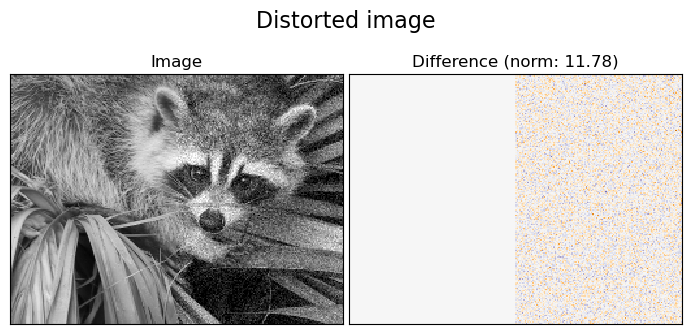

In [3]:
def show_with_diff(image, reference, title):
    plt.figure(figsize=(7, 3.3))
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title('Difference (norm: %.2f)' % np.sqrt(np.sum(difference**2)))
    plt.imshow(
        difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr, interpolation='nearest'
    )
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(.02, .02, .98, .79, .02, .2)

show_with_diff(distorted, raccoon_face, 'Distorted image')

## Extract reference patches

In [4]:
from time import time
from sklearn.feature_extraction.image import extract_patches_2d

# Extract patches from left half of the image
print('Extracting reference patches')
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[:, :width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print(f'{data.shape[0]} patches extracted in %.2fs.' % (time() - t0))

Extracting reference patches
22692 patches extracted in 0.01s.


# Baseline (Almost Serial_V2.py)

In [5]:
def kSVD_baseline(Y, T_0, k, num_iter, track_loss = True, verbose:int = 0, rng=42):
    loss = np.empty(num_iter)
    rng = np.random.default_rng(rng)

    # Initialize dictionary
    t0 = time()
    D = rng.standard_normal(size=(k, Y.shape[1]))
    D = (1 / LA.norm(D, ord=2, axis=1))[:, np.newaxis] * D

    if verbose > 0:
        print(f'Initialization Time: {time() - t0}')
    
    for iter in range(num_iter):
        t0 = 0
        if verbose > 0:
            print(f'Iteration {iter}:')
            t0 = time()
        
        # X = SparseCoder(dictionary = D, transform_n_nonzero_coefs = T_0).transform(Y)
        gram = D @ D.T
        cov = D @ Y.T
        X = sparse_encode(Y, 
                          D, #n_jobs=1,
                          algorithm='omp', 
                          n_nonzero_coefs = T_0,
                          gram = gram,
                          cov = cov,
                          copy_cov=False)
        if verbose > 0:
            print(f'\tCoding Time: {time() - t0}')
        
        t0 = time()
        unused_atom = False
        XD = X @ D
        for i in range(k):
            x_i = X[:, i]
            filter = (x_i != 0)
            x_i_R = x_i[filter]
            if x_i_R.shape[0] == 0:
                unused_atom=True
                continue

            # E_k_R = Y[filter]
            # E_k_R -= X[filter] @ D - X[filter, i][:, None] * D[i]
            XD[filter] -= X[filter, i][:, np.newaxis] * D[i]
            E_k_R = Y[filter] - XD[filter]

            U, S, Vh = LA.svd(E_k_R, full_matrices=False)

            X[filter, i] = U[:, 0] * S[0]
            D[i] = Vh[0]

            XD[filter] += X[filter, i][:, np.newaxis] * D[i]

        if verbose > 0:
            print(f'\tUpdate Time: {time() - t0}')
            print(f'\tUnused Atom: {unused_atom}')
        
        loss[iter] = LA.norm(Y - X @ D, ord='fro')

    return D, loss

# Improved Implementation (Serial_V2_1.py)

In [6]:
def kSVD_improved(Y, T_0, k, num_iter, track_loss = True, verbose:int = 0, rng=42):
    loss = np.empty(num_iter)
    rng = np.random.default_rng(rng)

    # Initialize dictionary
    t0 = time()
    D = rng.standard_normal(size=(k, Y.shape[1]))
    D /= LA.norm(D, ord=2, axis=1)[:, np.newaxis]

    if verbose > 0:
        print(f'Initialization Time: {time() - t0}')
    
    for iter in range(num_iter):
        t0 = 0
        if verbose > 0:
            print(f'Iteration {iter}:')
            t0 = time()
        
        gram = D @ D.T
        cov = D @ Y.T
        X = orthogonal_mp_gram(
            Gram=gram, 
            Xy=cov, 
            n_nonzero_coefs=T_0, 
            copy_Gram=False, 
            copy_Xy=False
        ).T # Transpose to match X shape
        if verbose > 0:
            print(f'\tCoding Time: {time() - t0}')
        
        t0 = time()
        unused_atom = False
        XD = X @ D
        # E_k_R = Y
        # E_k_R -= X @ D
        for i in range(k):
            x_i = X[:, i]
            # filter = (x_i != 0)
            filter = np.flatnonzero(x_i)
            x_i_R = x_i[filter]
            if x_i_R.shape[0] == 0:
                unused_atom=True
                continue
            
            res = X[filter, i][:, np.newaxis] * D[i]
            XD[filter] -= res
            E_k_R = Y[filter] - XD[filter]
            # E_k_R[filter] += X[filter, i][:, np.newaxis] * D[i]

            U, S, Vh = LA.svd(E_k_R, full_matrices=False)
            # U, S, Vh = LA.svd(E_k_R[filter], full_matrices=False)

            X[filter, i] = U[:, 0] * S[0]
            D[i] = Vh[0]

            XD[filter] += X[filter, i][:, np.newaxis] * D[i]
            # E_k_R[filter] -= X[filter, i][:, np.newaxis] * D[i]

        if verbose > 0:
            print(f'\tUpdate Time: {time() - t0}')
            print(f'\tUnused Atom: {unused_atom}')
        
        loss[iter] = LA.norm(Y - XD, ord='fro')
        # loss[iter] = LA.norm(E_k_R, ord='fro')

    return D, loss

In [7]:
def plot_log_loss(loss, linestyle='-', alpha = 1):
    plt.semilogy(loss, linestyle=linestyle, alpha = alpha)
    plt.title('Loss vs iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss (Log Scale)')
    # plt.show()

## Learn the dictionary from reference patches

### Hyperparams have been set to try to match those in the sklearn example and the results obtained for a more fair comparison!

In [8]:
num_iter = 2
Y = data

## Baseline

In [9]:
%%timeit
D, loss = kSVD_baseline(Y = Y,
               T_0 = 1, 
               k = 300, 
               num_iter = num_iter, 
               verbose=0,
                rng = rng) 

3.94 s ± 83.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Improved

In [10]:
%%timeit
D, loss = kSVD_improved(Y = Y,
                T_0 = 1, 
                k = 300, 
                num_iter = num_iter, 
                verbose=0,
                rng = rng) 

3.8 s ± 137 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(array([ 1.,  0.,  1.,  3.,  9., 16., 13.,  2.,  2.,  3.]),
 array([3.55020571, 3.59658253, 3.64295936, 3.68933618, 3.73571301,
        3.78208983, 3.82846665, 3.87484348, 3.9212203 , 3.96759713,
        4.01397395]),
 <BarContainer object of 10 artists>)

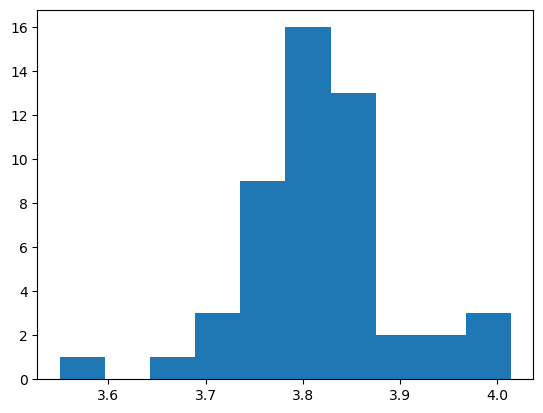

In [11]:
times = []
final_losses = []
for i in range(50):
    t0 = time()
    D, loss = kSVD_improved(Y = Y, 
                   T_0 = 1, 
                   k = 300, 
                   num_iter = num_iter, 
                   verbose=0,
                    rng = rng)
    times.append(time() - t0)
    final_losses.append(loss[-1])

plt.hist(times)

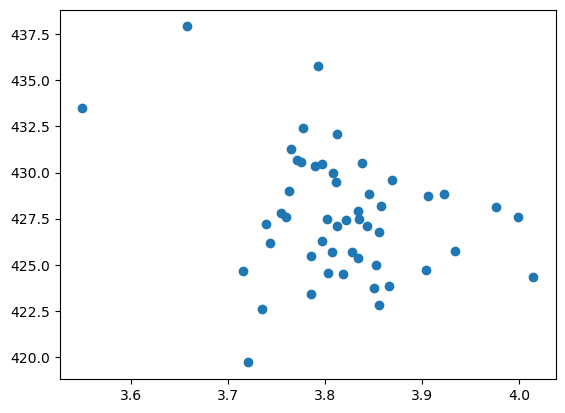

In [12]:
plt.scatter(times, final_losses)

# Going a little deeper with the profiling

## See https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html for a few examples

## Requires line_profiler to be installed if you want to run the following code locally !!!

In [13]:
# pip install line_profiler

In [14]:
%load_ext line_profiler

In [15]:
num_iter = 2
Y = data

## Baseline

In [16]:
from line_profiler import profile

l_kSVD_baseline = profile(kSVD_baseline)
%lprun -f l_kSVD_baseline l_kSVD_baseline(Y = Y, \
               T_0 = 1, \
               k = 300, \
               num_iter = num_iter, \
                verbose=0, rng = rng) 

Timer unit: 1e-07 s

Total time: 4.99313 s
File: C:\Users\richa\AppData\Local\Temp\ipykernel_12148\2845512668.py
Function: kSVD_baseline at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def kSVD_baseline(Y, T_0, k, num_iter, track_loss = True, verbose:int = 0, rng=42):
     2         1        103.0    103.0      0.0      loss = np.empty(num_iter)
     3         1         47.0     47.0      0.0      rng = np.random.default_rng(rng)
     4                                           
     5                                               # Initialize dictionary
     6         1         10.0     10.0      0.0      t0 = time()
     7         1       1986.0   1986.0      0.0      D = rng.standard_normal(size=(k, Y.shape[1]))
     8         1       3211.0   3211.0      0.0      D = (1 / LA.norm(D, ord=2, axis=1))[:, np.newaxis] * D
     9                                           
    10         1         11.0     11.0    

## Improved

In [17]:
l_kSVD_improved = profile(kSVD_improved)
%lprun -f l_kSVD_improved l_kSVD_improved(Y = Y, \
               T_0 = 1, \
               k = 300, \
               num_iter = num_iter, \
                verbose=0, rng = rng) 

Timer unit: 1e-07 s

Total time: 4.97856 s
File: C:\Users\richa\AppData\Local\Temp\ipykernel_12148\4179300726.py
Function: kSVD_improved at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def kSVD_improved(Y, T_0, k, num_iter, track_loss = True, verbose:int = 0, rng=42):
     2         1         75.0     75.0      0.0      loss = np.empty(num_iter)
     3         1         38.0     38.0      0.0      rng = np.random.default_rng(rng)
     4                                           
     5                                               # Initialize dictionary
     6         1         10.0     10.0      0.0      t0 = time()
     7         1       4191.0   4191.0      0.0      D = rng.standard_normal(size=(k, Y.shape[1]))
     8         1       2033.0   2033.0      0.0      D /= LA.norm(D, ord=2, axis=1)[:, np.newaxis]
     9                                           
    10         1          7.0      7.0      0.0    

## Requires memory_profiler to be installed if you want to run the following code locally !!!

In [18]:
# pip install memory_profiler

In [19]:
%load_ext memory_profiler

In [20]:
num_iter = 2
Y = data

## Baseline

In [21]:
%memit kSVD_baseline(Y = Y, \
               T_0 = 1, \
               k = 300, \
               num_iter = num_iter, \
                verbose=0, rng = rng) 

peak memory: 356.08 MiB, increment: 135.01 MiB


## Improved

In [22]:
%memit kSVD_improved(Y = Y, \
               T_0 = 1, \
               k = 300, \
               num_iter = num_iter, \
              verbose=0, rng = rng) 

peak memory: 360.68 MiB, increment: 137.00 MiB
